# U-Net Image Segmentation 
## Learning Multi-Class Segmentations From Single-Class Datasets
trying to implement the paper (source: https://openaccess.thecvf.com/content_CVPR_2019/papers/Dmitriev_Learning_Multi-Class_Segmentations_From_Single-Class_Datasets_CVPR_2019_paper.pdf)

We used colab to run this notebook.

We followed this toturial:
(source: https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)


## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# tensorflow and keras
import tensorflow as tf
from tensorflow.random import uniform
from keras import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Dropout, concatenate
from keras.metrics import CategoricalAccuracy, MeanIoU
from keras.utils import array_to_img, plot_model
from keras.optimizers import Adam
import tensorflow_datasets as tfds

## Load data from Tensorflow Datasets
In this notebook we used the 'oxford_iiit_pet' which is recently updated data instead of the old 'Pascal VOC 2012'

(source: https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)

The Oxford-IIIT Pet dataset was first released in 2012 by the University of Oxford and the Indian Institute of Technology (IIIT), hence the name "Oxford-IIIT Pet". The dataset consists of images of cats and dogs with annotated pixel-level segmentation masks.

Since its initial release, the Oxford-IIIT Pet dataset has undergone some updates and improvements. The most recent version of the dataset (as of my knowledge cutoff of September 2021) was released in 2019, which includes additional annotations and new images.

Here are the details of the release dates of the Oxford-IIIT Pet dataset versions:

- Original release: 2012
- Updated release: 2013
- New images added: 2014
- Annotation improvements: 2015
- Additional annotations and new images: 2019

It's worth noting that while the dataset has been updated over the years, the original images and annotations have remained the same, so the dataset is still comparable to earlier works that used it.

The Oxford-IIIT Pet dataset is a dataset of images of cats and dogs with pixel-level segmentation masks. Each pixel in the segmentation mask is labeled with one of three possible classes:

- Class 1 (background): This class represents the background pixels, i.e., the pixels that do not belong to either the cat or the dog in the image.

- Class 2 (cat): This class represents the pixels that belong to the cat in the image.

- Class 3 (dog): This class represents the pixels that belong to the dog in the image.

So the Oxford-IIIT Pet dataset has a total of three output classes: background, cat, and dog. When training an image segmentation model on this dataset, the goal is to predict a segmentation mask for each input image that accurately labels each pixel as belonging to one of these three classes.

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

## Data preprocessing

### Resize Images 
resize images to to 64×64 just to fasten the process

In [4]:
image_size = (64, 64)
def resize(image, mask):
    image = tf.image.resize(image, image_size, method="nearest")
    mask = tf.image.resize(mask, image_size, method="nearest")
    return image, mask 

### Rotate Images

In [5]:
def rotate(image, mask):
    if uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    return image, mask

### Normalize Images
Normalize Images by dividing the image pixels by 255 to make it in the range [0, 1]

In [6]:
def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    return image, mask

### Split data
split main dataset to train and test data and preprocess the data

In [7]:
batch_size = 16
validation_size = 3000
buffer_size = 1000
epochs = 10
validation_sub_splits = 5
num_classes = 3

#### Preprocess Training data

In [8]:
def load_train_data(train_data):
    image = train_data["image"]
    mask = train_data["segmentation_mask"]
    image, mask = resize(image, mask)
    image, mask = rotate(image, mask)
    image, mask = normalize(image, mask)
    return image, mask

In [9]:
train_images = dataset["train"].map(load_train_data, num_parallel_calls=tf.data.AUTOTUNE)
train_images

<_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64, 64, 1), dtype=tf.uint8, name=None))>

In [10]:
train_batches = train_images.cache().shuffle(buffer_size).batch(batch_size).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.uint8, name=None))>

### Identify the training epochs

In [11]:
train_length = len(train_images)
steps_per_epoch = np.ceil(train_length / batch_size)

#### Preprocess Testing data

In [12]:
def load_test_data(test_data):
    image = test_data["image"]
    mask = test_data["segmentation_mask"]
    image, mask = resize(image, mask)
    image, mask = normalize(image, mask)
    return image, mask

In [13]:
test_images = dataset["test"].map(load_test_data, num_parallel_calls=tf.data.AUTOTUNE)
test_images

<_ParallelMapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64, 64, 1), dtype=tf.uint8, name=None))>

### Split Test Data
split test data to test and validation

In [14]:
validation_batches = test_images.take(validation_size).batch(batch_size)
validation_batches

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.uint8, name=None))>

In [15]:
test_batches = test_images.skip(validation_size).take(len(test_images) - validation_size).batch(batch_size)
test_batches

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.uint8, name=None))>

### Identify the training epochs

In [16]:
test_length = len(test_images) - validation_size
validation_steps = np.ceil(test_length / (batch_size * validation_sub_splits))

## Data Visualization

In [17]:
def display_prediction(display_size=0, image=None, t_mask=None, p_mask=None):
  plt.figure(figsize=(10, 10))

  if display_size >= 1:
      plt.subplot(1, 3, 1)
      plt.title('Image')
      plt.imshow(array_to_img(image))
      plt.axis('off')

  if display_size >= 2:
      plt.subplot(1, 3, 2)
      plt.title('True Mask')
      plt.imshow(array_to_img(t_mask))
      plt.axis('off')

  if display_size == 3:
      plt.subplot(1, 3, 3)
      plt.title('Predicted Mask')
      plt.imshow(array_to_img(p_mask))
      plt.axis('off')

  plt.show()

### Visualization Example

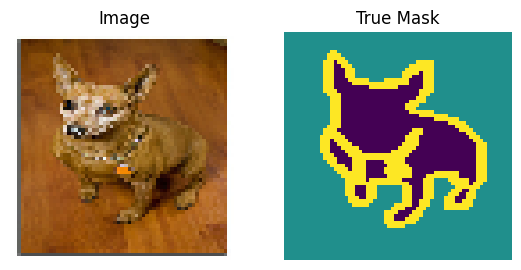

In [18]:
test_batch = next(iter(test_batches))
image0, mask0 = test_batch[0][0], test_batch[1][0]
display_prediction(2, image0, mask0)

## Create Model

### U-Net Model Layers
Create the building Layers for the model. 

In [19]:
def conv_layer(x, n_filters):
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

In [20]:
def downsample_layer(x, n_filters):
    f = conv_layer(x, n_filters)
    p = MaxPool2D(2)(f)
    p = Dropout(0.3)(p)
    return f, p

In [21]:
def upsample_layer(x, conv_features, n_filters):
    x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)
    x = conv_layer(x, n_filters)
    return x

### Build the U-Net Model

In [22]:
def create_model():

    inputs = Input(shape=(*image_size, 3))

    f1, p = downsample_layer(inputs, 64)
    f2, p = downsample_layer(p, 128)

    bottleneck = conv_layer(p, 1024)

    u = upsample_layer(bottleneck, f2, 512)
    u = upsample_layer(u, f1, 256)

    outputs = Conv2D(num_classes, 1, padding="same", activation = "softmax")(u)

    return Model(inputs, outputs, name="U-Net")

In [23]:
tf.keras.backend.clear_session()
model = create_model()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

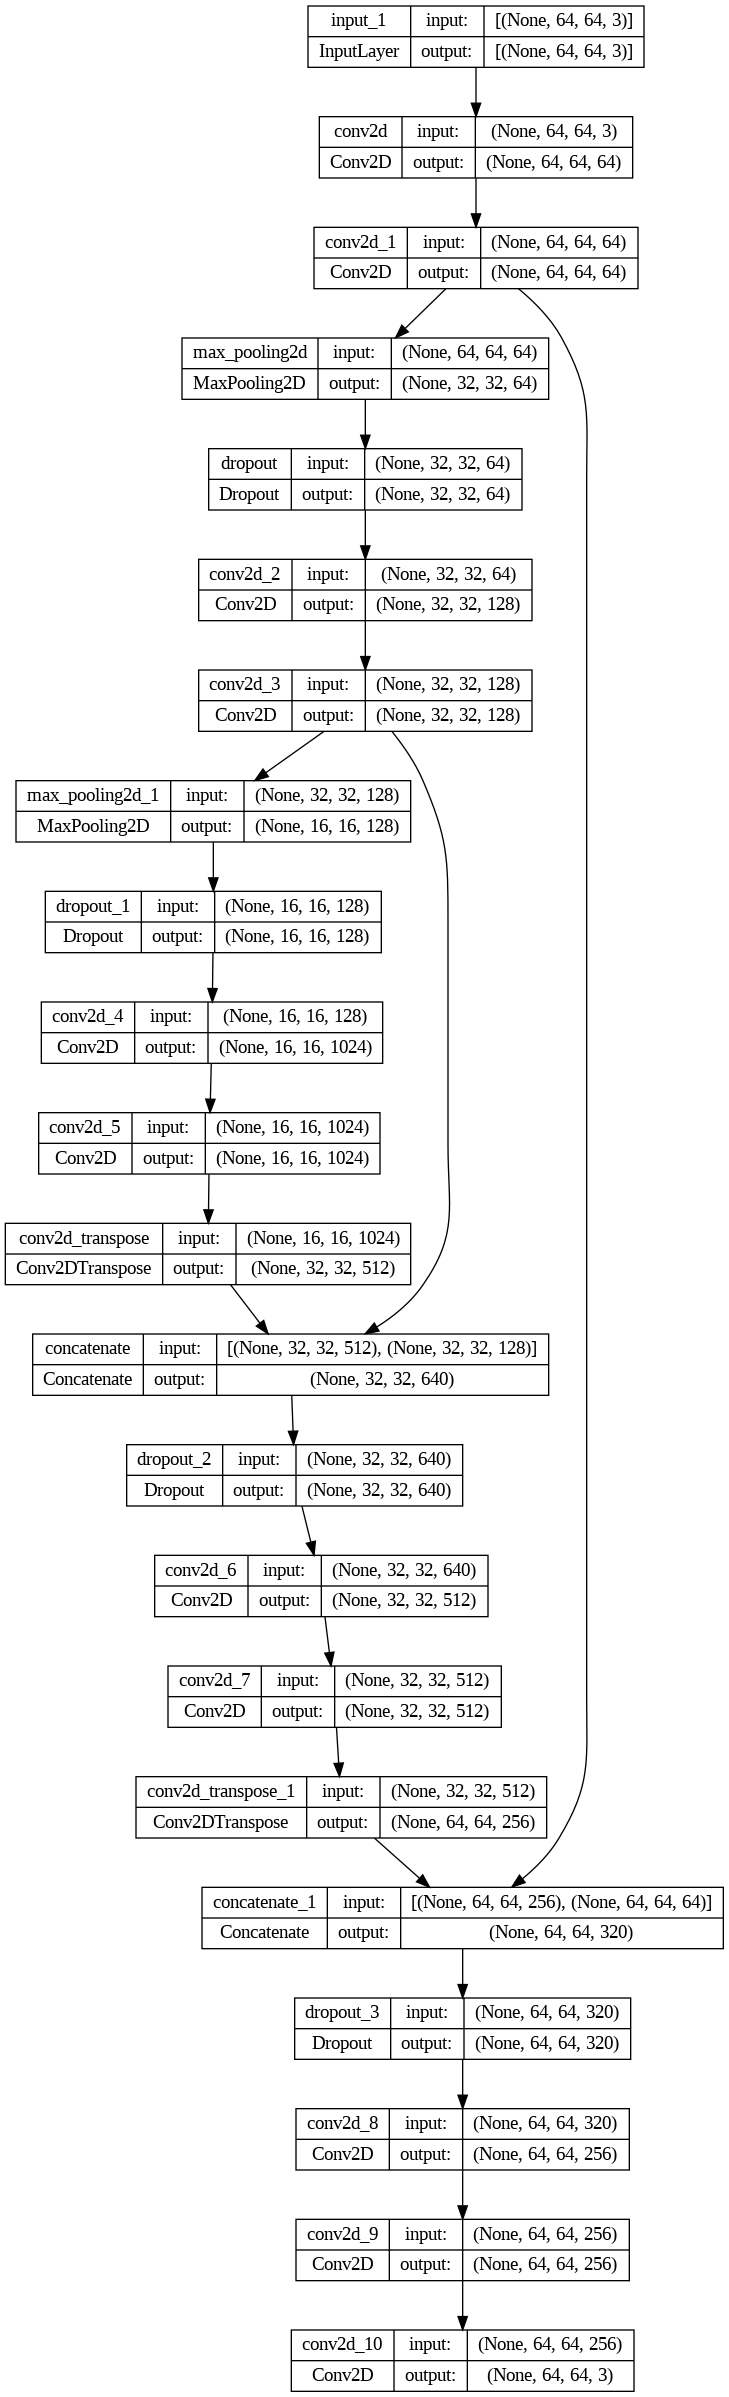

In [25]:
plot_model(model, show_shapes=True)

## Train Model

In [26]:
model_history = model.fit(train_batches, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_data=validation_batches)

Epoch 1/10
230/230 [==============================] - 70s 229ms/step - loss: 1.3790 - accuracy: 0.6502 - val_loss: 0.6550 - val_accuracy: 0.7370
Epoch 2/10
230/230 [==============================] - 52s 228ms/step - loss: 0.6333 - accuracy: 0.7448 - val_loss: 0.5631 - val_accuracy: 0.7754
Epoch 3/10
230/230 [==============================] - 53s 232ms/step - loss: 0.5841 - accuracy: 0.7690 - val_loss: 0.5495 - val_accuracy: 0.7775
Epoch 4/10
230/230 [==============================] - 52s 228ms/step - loss: 0.5396 - accuracy: 0.7876 - val_loss: 0.5208 - val_accuracy: 0.7914
Epoch 5/10
230/230 [==============================] - 53s 232ms/step - loss: 0.5110 - accuracy: 0.8000 - val_loss: 0.4642 - val_accuracy: 0.8179
Epoch 6/10
230/230 [==============================] - 52s 227ms/step - loss: 0.4805 - accuracy: 0.8129 - val_loss: 0.4988 - val_accuracy: 0.8053
Epoch 7/10
230/230 [==============================] - 52s 226ms/step - loss: 0.4672 - accuracy: 0.8189 - val_loss: 0.4632 - val_ac

## Learning curves

In [31]:
def display_accuracy(history):
    plt.figure(figsize=(5,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracies')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [32]:
def display_losses(history):
    plt.figure(figsize=(5,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

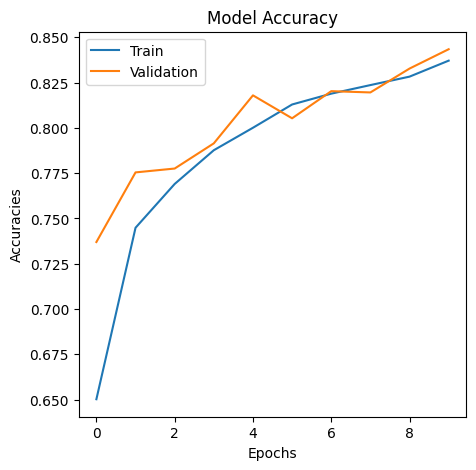

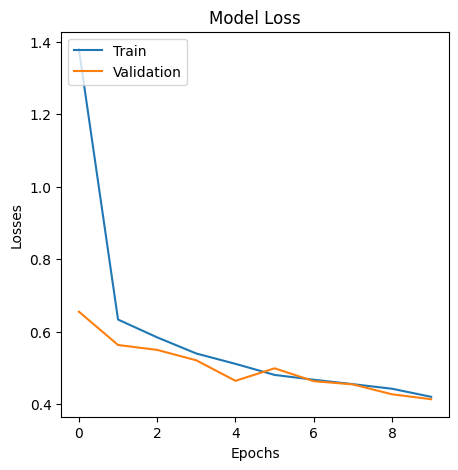

In [33]:
def display_curves(history):
    display_accuracy(history)
    print()
    display_losses(history)

display_curves(model_history)

## Predictions with U-Net model
- Predict 
- display
- calculate the IoU

In [49]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [50]:
def calculate_mean_IoU(y_true, y_pred):
    iou_metric = MeanIoU(num_classes=num_classes)
    iou_metric.update_state(y_true, y_pred)
    # Calculate the IoU
    iou = iou_metric.result().numpy()
    print("IoU: ", iou)
    return iou

In [53]:
def show_predictions(model, dataset):
    iou_metrics = []
    for image, mask in dataset:
        pred_mask = model.predict(image)
        pred_mask = create_mask(pred_mask)
        iou_metrics.append(calculate_mean_IoU(mask[0], pred_mask[0]))
        display_prediction(3, image[0], mask[0], pred_mask[0])
    return iou_metrics

1/1 [==============================] - 0s 33ms/step
IoU:  0.46856228


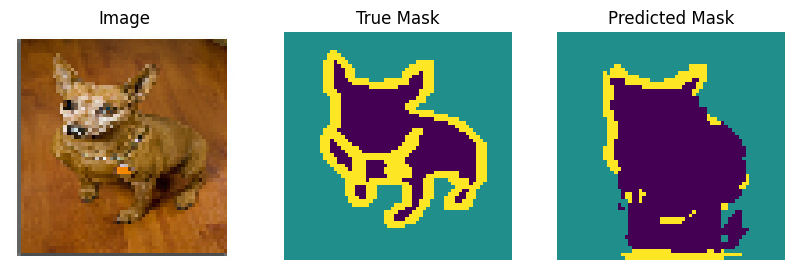

1/1 [==============================] - 0s 31ms/step
IoU:  0.2842432


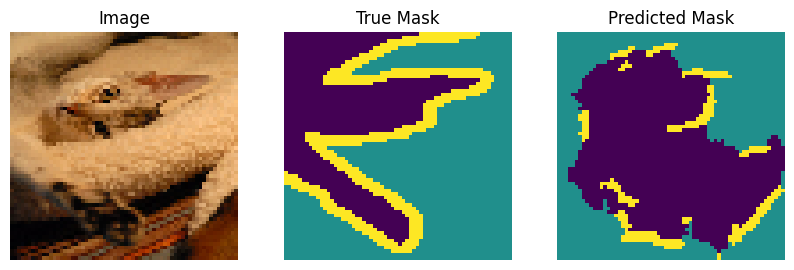

1/1 [==============================] - 0s 44ms/step
IoU:  0.5583069


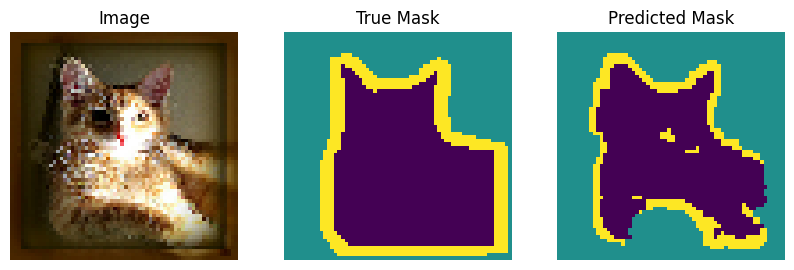

1/1 [==============================] - 0s 31ms/step
IoU:  0.7443977


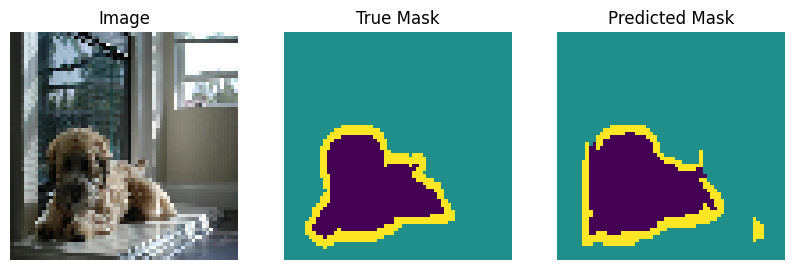

1/1 [==============================] - 0s 20ms/step
IoU:  0.65374225


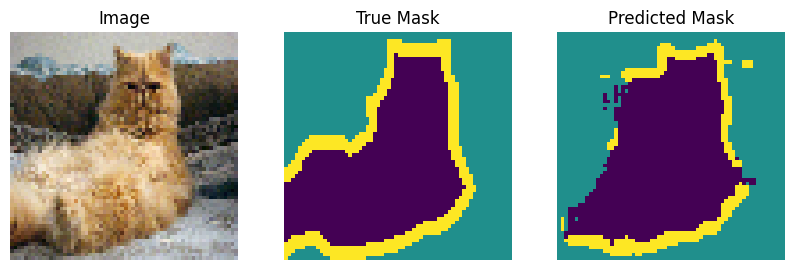

1/1 [==============================] - 0s 28ms/step
IoU:  0.64176637


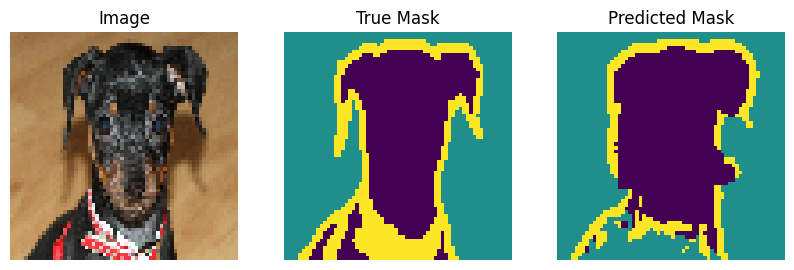

1/1 [==============================] - 0s 23ms/step
IoU:  0.83096933


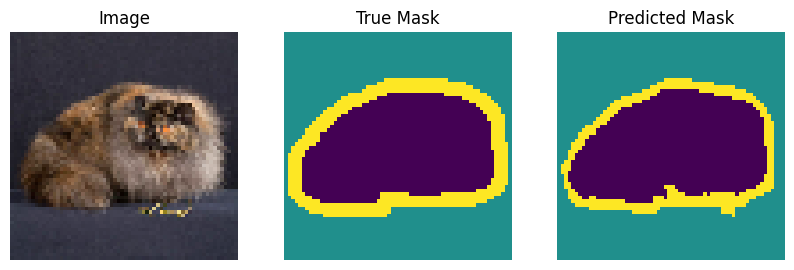

1/1 [==============================] - 0s 26ms/step
IoU:  0.74719


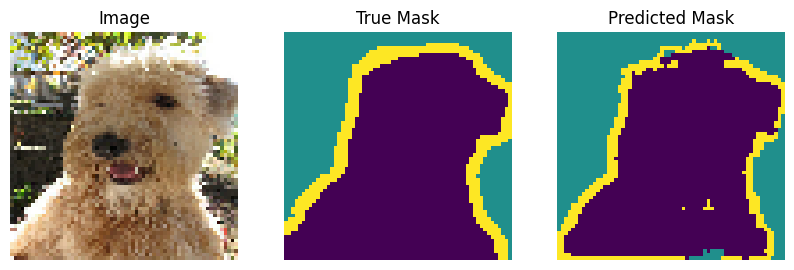

1/1 [==============================] - 0s 38ms/step
IoU:  0.73218983


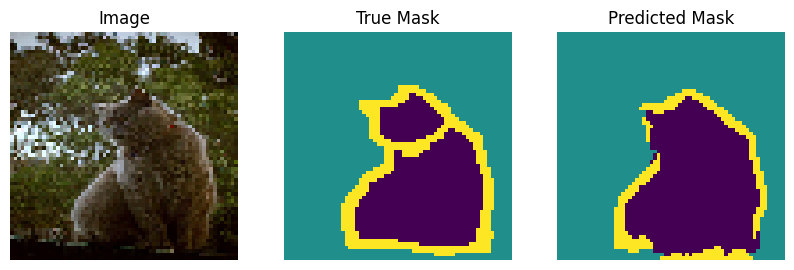

1/1 [==============================] - 0s 30ms/step
IoU:  0.4898833


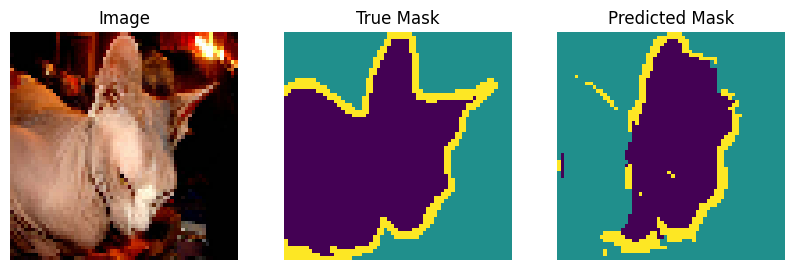

1/1 [==============================] - 0s 30ms/step
IoU:  0.6848044


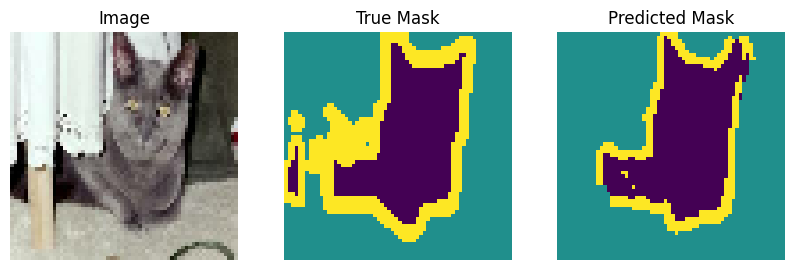

1/1 [==============================] - 0s 26ms/step
IoU:  0.661652


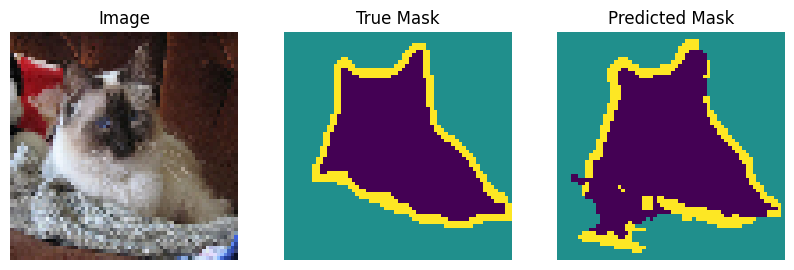

1/1 [==============================] - 0s 21ms/step
IoU:  0.5688965


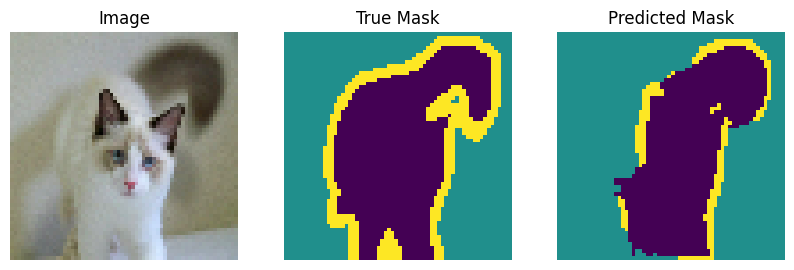

1/1 [==============================] - 0s 31ms/step
IoU:  0.5814896


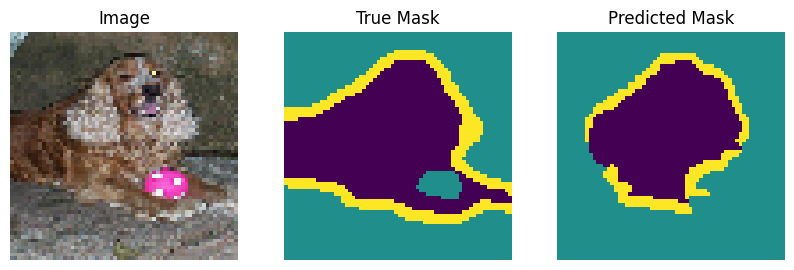

1/1 [==============================] - 0s 23ms/step
IoU:  0.6432813


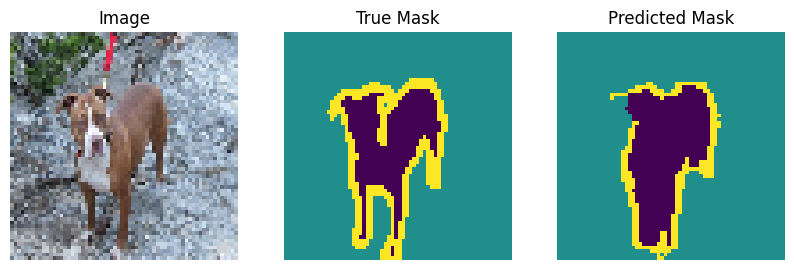

1/1 [==============================] - 0s 21ms/step
IoU:  0.5352199


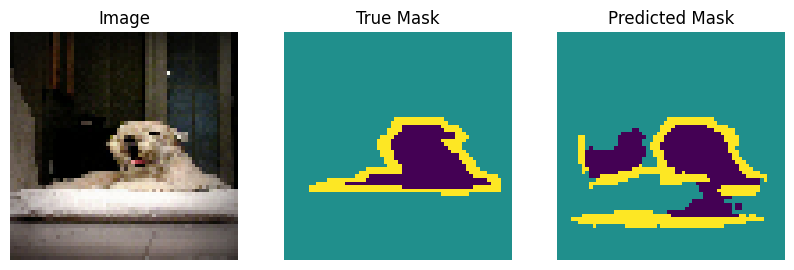

1/1 [==============================] - 0s 24ms/step
IoU:  0.6810346


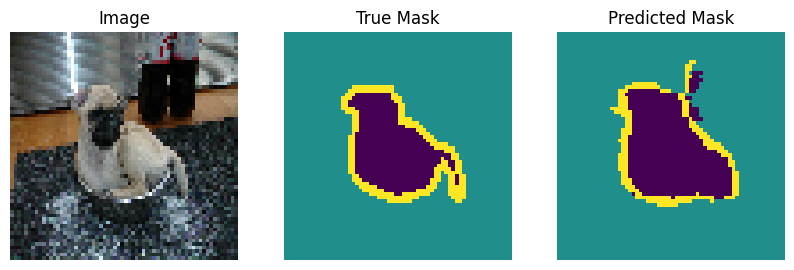

1/1 [==============================] - 0s 20ms/step
IoU:  0.6855338


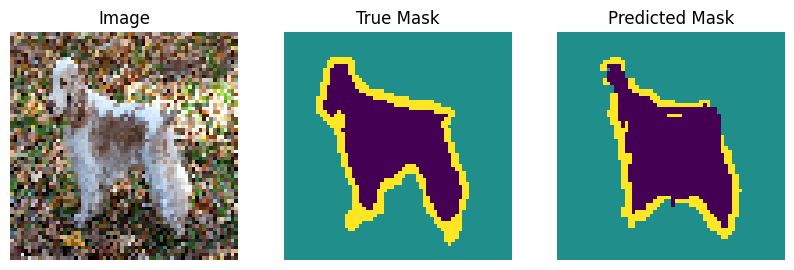

1/1 [==============================] - 0s 20ms/step
IoU:  0.5358859


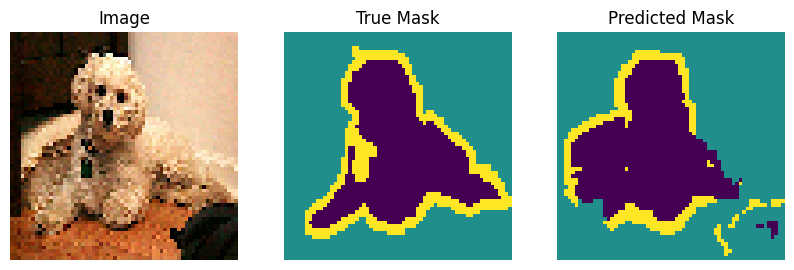

1/1 [==============================] - 0s 22ms/step
IoU:  0.60621184


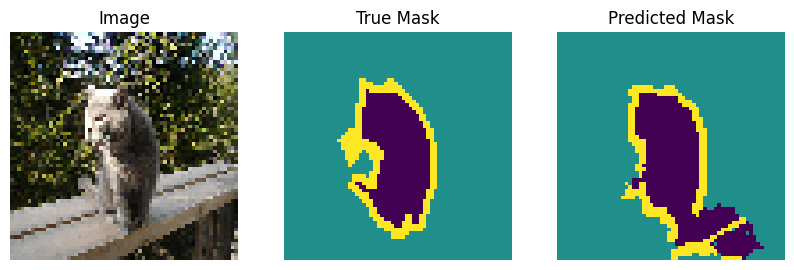

1/1 [==============================] - 0s 30ms/step
IoU:  0.7167275


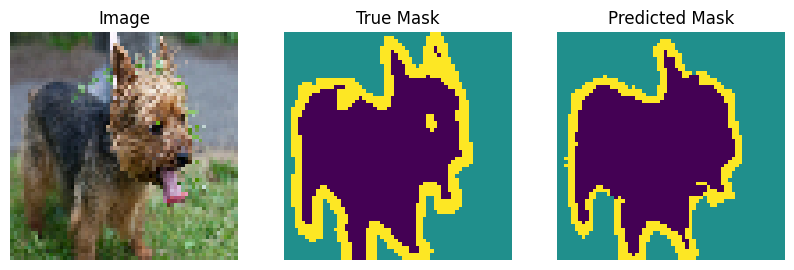

1/1 [==============================] - 0s 28ms/step
IoU:  0.53596425


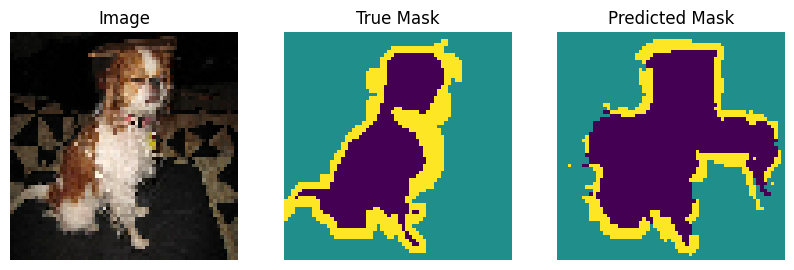

1/1 [==============================] - 0s 23ms/step
IoU:  0.5490854


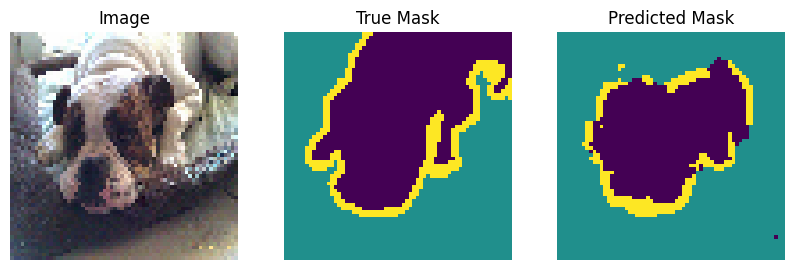

1/1 [==============================] - 0s 20ms/step
IoU:  0.65232205


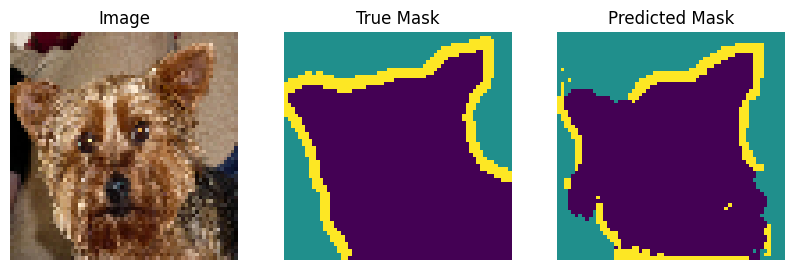

1/1 [==============================] - 0s 20ms/step
IoU:  0.7975243


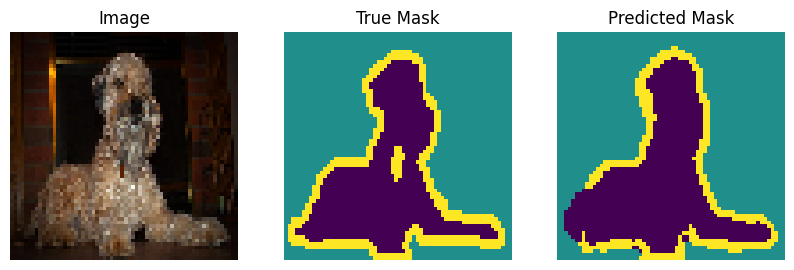

1/1 [==============================] - 0s 37ms/step
IoU:  0.327679


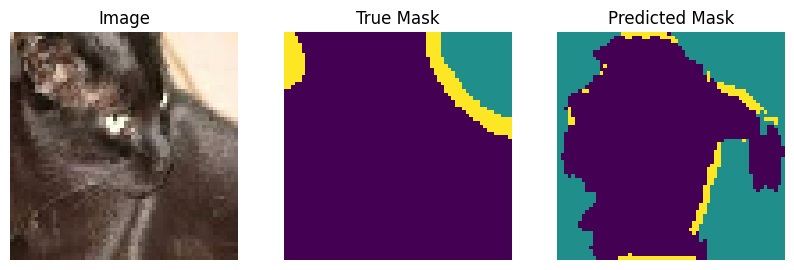

1/1 [==============================] - 0s 22ms/step
IoU:  0.5237194


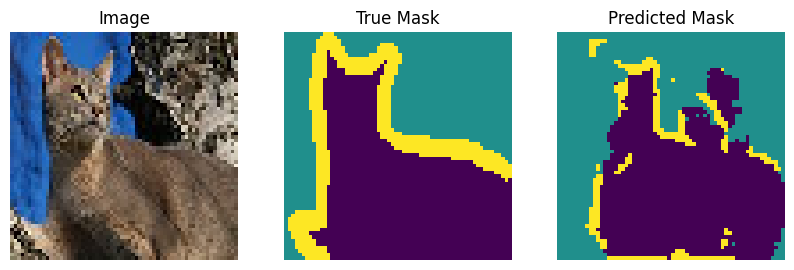

1/1 [==============================] - 0s 28ms/step
IoU:  0.39836904


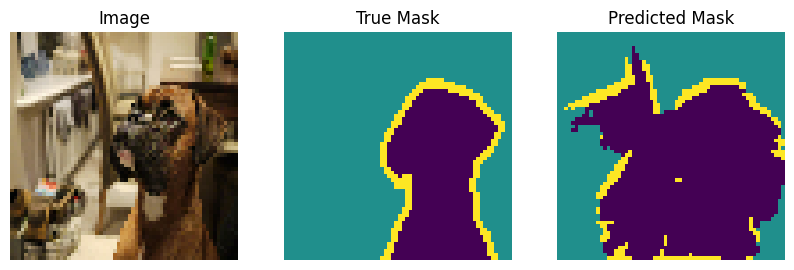

1/1 [==============================] - 0s 24ms/step
IoU:  0.7139098


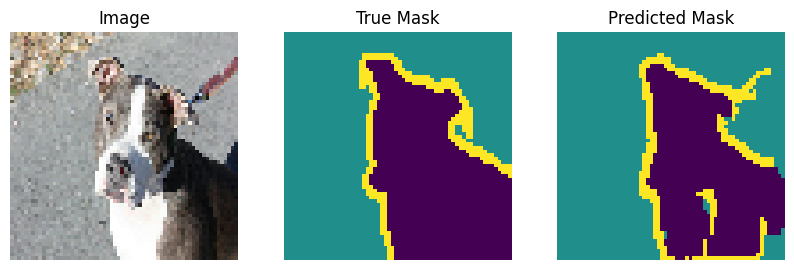

1/1 [==============================] - 0s 35ms/step
IoU:  0.62898225


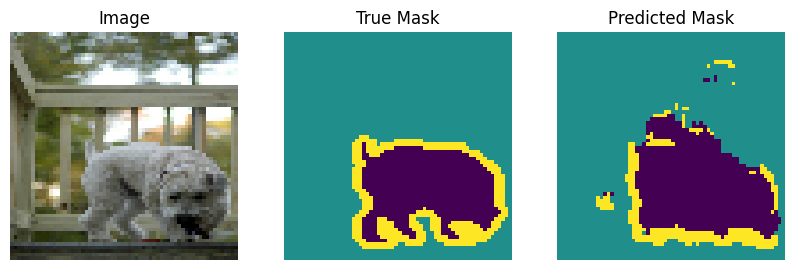

1/1 [==============================] - 0s 21ms/step
IoU:  0.48013678


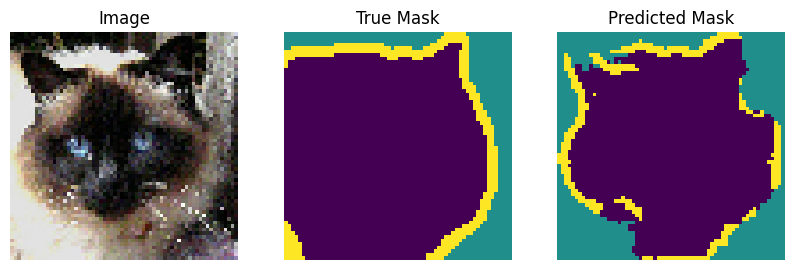

1/1 [==============================] - 0s 42ms/step
IoU:  0.7381919


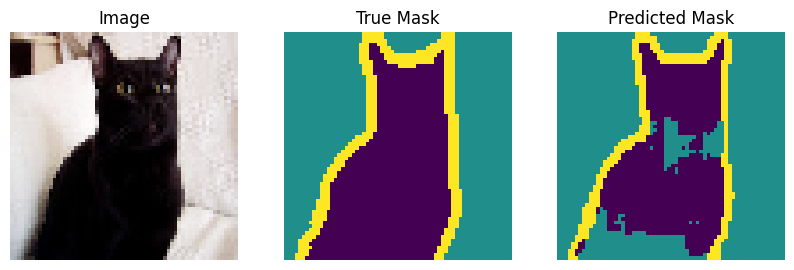

1/1 [==============================] - 0s 27ms/step
IoU:  0.6313816


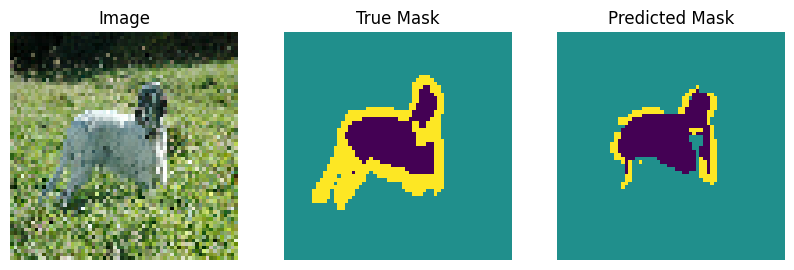

1/1 [==============================] - 0s 34ms/step
IoU:  0.60416925


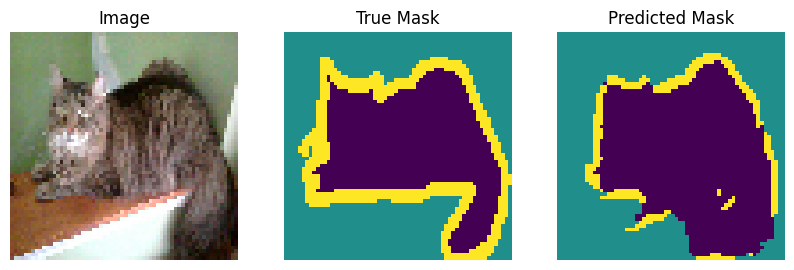

1/1 [==============================] - 0s 33ms/step
IoU:  0.4210846


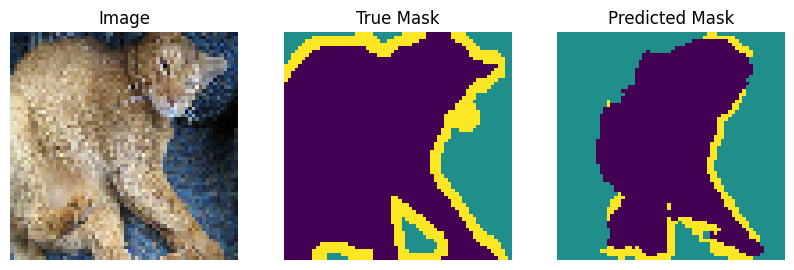

1/1 [==============================] - 0s 54ms/step
IoU:  0.5060205


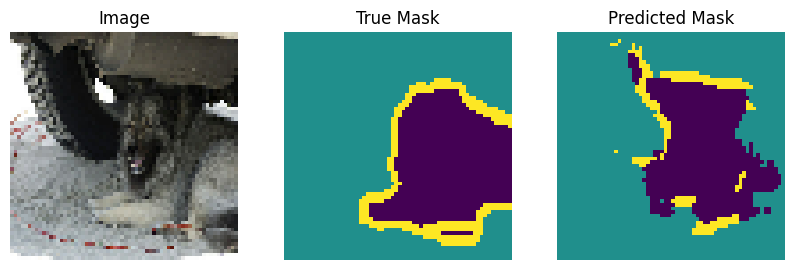

1/1 [==============================] - 0s 49ms/step
IoU:  0.74984425


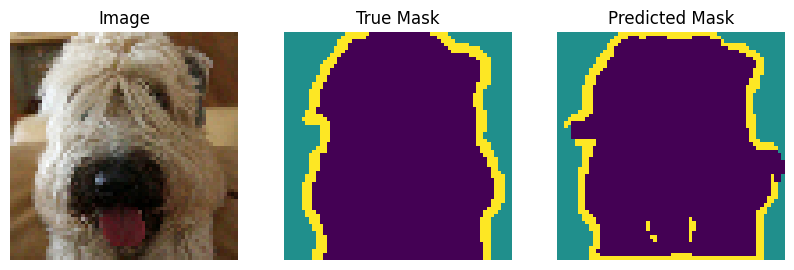

1/1 [==============================] - 0s 29ms/step
IoU:  0.71009845


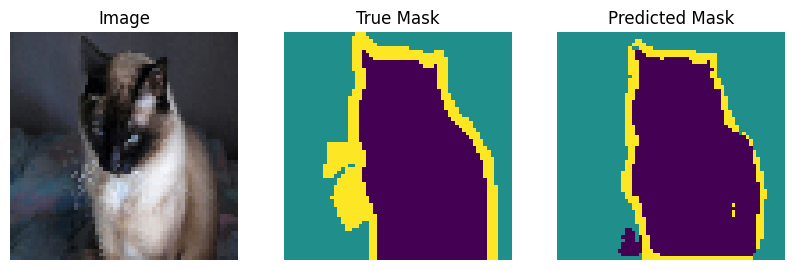

1/1 [==============================] - 0s 23ms/step
IoU:  0.73179585


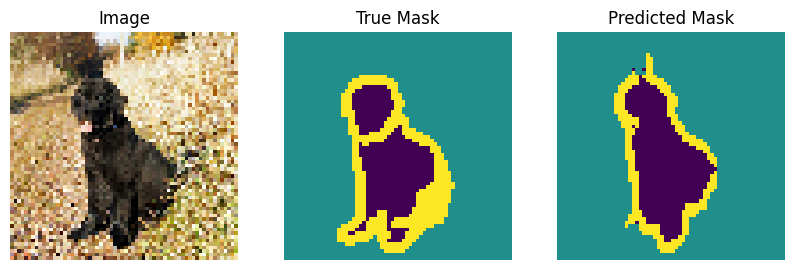

1/1 [==============================] - 0s 28ms/step
IoU:  0.8248091


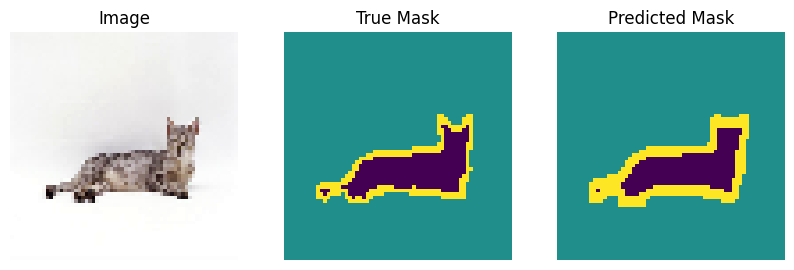

1/1 [==============================] - 0s 21ms/step
IoU:  0.8098378


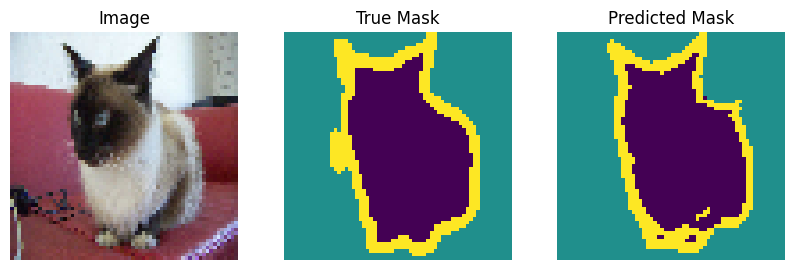

1/1 [==============================] - 0s 25ms/step
IoU:  0.48716745


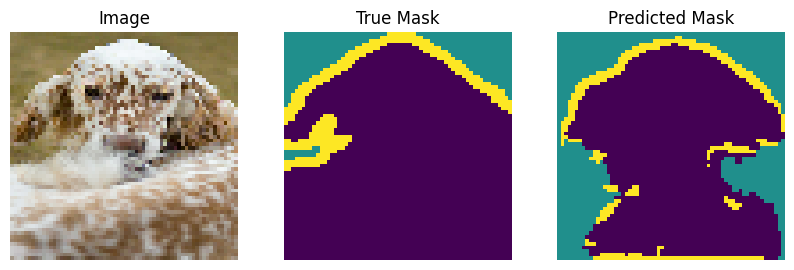

In [54]:
iou_metrics = show_predictions(model, test_batches)

In [55]:
print(f'Mean IoU of the model is: {np.mean(iou_metrics)}')

Mean IoU of the model is: 0.6160495281219482
